In [75]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from econml.grf import CausalForest
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve

from matplotlib import pyplot as plt

# Pre-process data

In [76]:
data = pd.read_csv("bsc_project_set.csv", index_col=0)

xs = data.copy()

y = xs["mort_28"]
w = xs["peep_regime"]

w = pd.Series(map(lambda x: 0 if x == "low" else 1, w))
y = pd.Series(map(lambda x: 1 if x == False else 0, y))

selected_columns = ["age", "weight", "pf_ratio", "po2", "pco2", "driving_pressure", "bilirubin", "platelets", "urea", "fio2", "minute_volume", "plateau_pressure"]
xs = xs[selected_columns]
columns_x = xs.columns

norm_xs = (xs - xs.mean())/xs.std()

imputer = KNNImputer(n_neighbors=2, weights="uniform")
imp_xs = imputer.fit_transform(norm_xs)

imp_xs = pd.DataFrame(data=imp_xs, columns=columns_x)

imp_xs

,age,weight,pf_ratio,po2,pco2,driving_pressure,bilirubin,platelets,urea,fio2,minute_volume,plateau_pressure
0,0.732971,0.183841,-0.026374,-0.049713,-1.422636,-0.364306,1.121030,-1.048713,-0.897592,-0.564826,-0.543738,0.705302
1,-1.005004,1.422974,-0.637005,-0.385550,-0.768253,-1.141620,2.210067,-1.629822,2.693985,0.758913,3.032717,-0.620678
2,1.353676,-0.381057,-0.171336,-0.406111,-0.403630,1.468983,0.409822,-0.668334,0.703662,-0.434729,-0.035368,0.317210
3,1.353676,0.100018,-0.319055,-1.169822,-0.403630,1.395651,-0.190259,0.023680,1.738181,-1.503965,-0.868889,0.640620
4,0.050195,-0.654395,-0.577049,-0.737052,-0.334933,-1.072479,-0.531046,2.898673,-0.720674,-0.385943,-1.051634,-1.236080
...,...,...,...,...,...,...,...,...,...,...,...,...
3936,0.919183,-1.128181,-0.711144,0.068026,-0.395043,1.219655,-0.068020,0.112283,0.478767,0.541000,-0.428608,0.252528
3937,0.732971,0.475402,-0.527518,-0.793421,-0.300585,-0.540301,-0.501413,-1.092709,2.250942,-0.411497,-0.966353,-1.028174
3938,0.236407,0.438957,-0.701828,-0.554080,0.137359,0.281012,0.325366,1.026414,0.532742,1.377339,-0.299739,1.869576
3939,0.298477,0.245798,-0.425805,-0.814696,-0.156321,0.075683,0.009768,-0.423609,-0.522017,0.150708,-0.298318,0.113924


In [50]:
full_data = imp_xs.assign(W=w, Y=y)

train, test = train_test_split(full_data, test_size=0.3)

## Train models with default parameters

In [51]:
train_x = train[columns_x]
test_x = test[columns_x]

# S-learner
regr_s = RandomForestRegressor()
regr_s.fit(train.drop(columns=["Y"]), train["Y"])

# T-learner
regr0_t = RandomForestRegressor()
regr1_t = RandomForestRegressor()
regr0_t.fit(train.query("W==0").drop(columns=["W", "Y"]), train.query("W==0")["Y"])
regr1_t.fit(train.query("W==1").drop(columns=["W", "Y"]), train.query("W==1")["Y"])

# Causal forest
causal_forest = CausalForest()
causal_forest.fit(X=train_x, T=train["W"], y=train["Y"])

CausalForest()

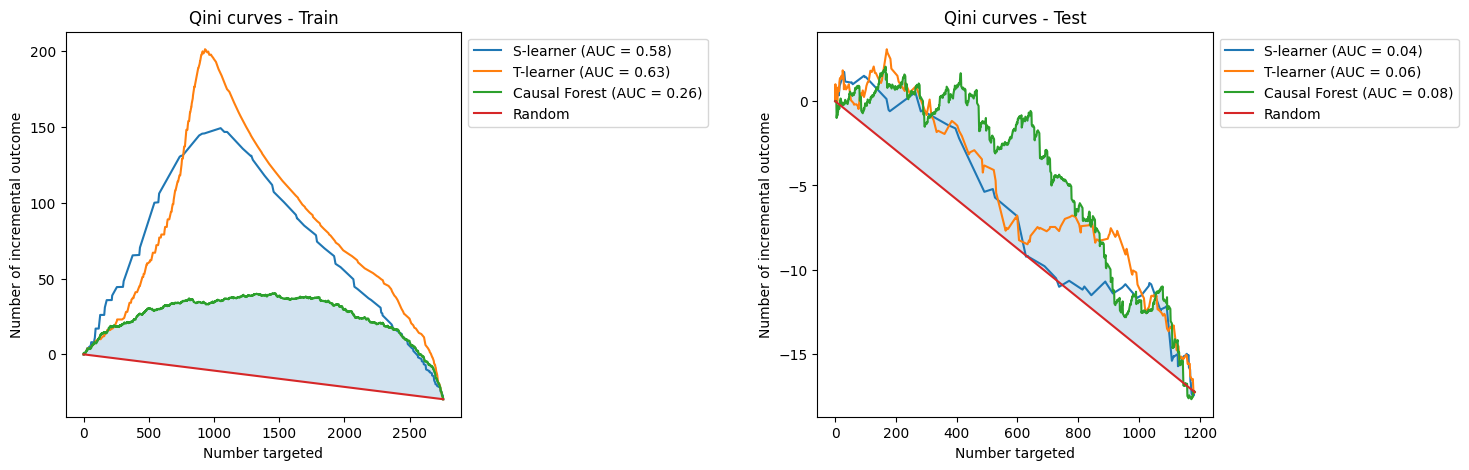

In [52]:
# orig size: (6.4, 4.8)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14.8, 5))
plt.subplots_adjust(wspace=0.9)
ax1.set_title('Qini curves - Train')

plot_qini_curve(y_true=train["Y"].to_list(), uplift=regr_s.predict(train_x.assign(**{"W": 1})) - regr_s.predict(train_x.assign(**{"W": 0})), treatment=train["W"].to_list(), perfect=False, random=False, name="S-learner", ax=ax1)

plot_qini_curve(y_true=train["Y"].to_list(), uplift=(regr1_t.predict(train_x) - regr0_t.predict(train_x)).tolist(), treatment=train["W"].to_list(), perfect=False, random=False, name="T-learner", ax=ax1)

plot_qini_curve(y_true=train["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=train_x)).tolist(), treatment=train["W"].to_list(), perfect=False, name="Causal Forest", ax=ax1)

ax2.set_title('Qini curves - Test')

plot_qini_curve(y_true=test["Y"].to_list(), uplift=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})), treatment=test["W"].to_list(), perfect=False, random=False, name="S-learner", ax=ax2)

plot_qini_curve(y_true=test["Y"].to_list(), uplift=(regr1_t.predict(test_x) - regr0_t.predict(test_x)).tolist(), treatment=test["W"].to_list(), perfect=False, random=False, name="T-learner", ax=ax2)

plot_qini_curve(y_true=test["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=test_x)).tolist(), treatment=test["W"].to_list(), perfect=False, name="Causal Forest", ax=ax2)

# Qini AUC Tests (default parameters)

In [53]:
def run_qini_test(reps, full_data):

    score_s_train = []
    score_t_train = []
    score_forest_train = []

    score_s_test = []
    score_t_test = []
    score_forest_test = []

    for i in range(reps):
        train, test = train_test_split(full_data, test_size=0.3)

        train_x = train[columns_x]
        test_x = test[columns_x]

        # S-learner
        regr_s = RandomForestRegressor()
        regr_s.fit(train.drop(columns=["Y"]), train["Y"])

        # T-learner
        regr0_t = RandomForestRegressor()
        regr1_t = RandomForestRegressor()
        regr0_t.fit(train.query("W==0").drop(columns=["W", "Y"]), train.query("W==0")["Y"])
        regr1_t.fit(train.query("W==1").drop(columns=["W", "Y"]), train.query("W==1")["Y"])

        # Causal forest
        causal_forest = CausalForest()
        causal_forest.fit(X=train_x, T=train["W"], y=train["Y"])

        score_s_train.append(qini_auc_score(y_true=train["Y"].to_list(), uplift=regr_s.predict(train_x.assign(**{"W": 1})) - regr_s.predict(train_x.assign(**{"W": 0})), treatment=train["W"].to_list()))
        score_t_train.append(qini_auc_score(y_true=train["Y"].to_list(), uplift=(regr1_t.predict(train_x) - regr0_t.predict(train_x)).tolist(), treatment=train["W"].to_list()))
        score_forest_train.append(qini_auc_score(y_true=train["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=train_x)).tolist(), treatment=train["W"].to_list()))

        score_s_test.append(qini_auc_score(y_true=test["Y"].to_list(), uplift=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})), treatment=test["W"].to_list()))
        score_t_test.append(qini_auc_score(y_true=test["Y"].to_list(), uplift=(regr1_t.predict(test_x) - regr0_t.predict(test_x)).tolist(), treatment=test["W"].to_list()))
        score_forest_test.append(qini_auc_score(y_true=test["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=test_x)).tolist(), treatment=test["W"].to_list()))

    data = {
        "S-learner": [np.mean(score_s_train), np.std(score_s_train, ddof=1), np.mean(score_s_test), np.std(score_s_test, ddof=1)],
        "T-learner": [np.mean(score_t_train), np.std(score_t_train, ddof=1), np.mean(score_t_test), np.std(score_t_test, ddof=1)],
        "Causal Forest": [np.mean(score_forest_train), np.std(score_forest_train, ddof=1), np.mean(score_forest_test), np.std(score_forest_test, ddof=1)]
    }

    return pd.DataFrame.from_dict(data, orient='index', columns=["Mean AUC - Train", "Std - Train", "Mean AUC - Test", "Std - Test"])

In [54]:
full_data = imp_xs.assign(W=w, Y=y)

In [55]:
run_qini_test(500, full_data)

,Mean AUC - Train,Std - Train,Mean AUC - Test,Std - Test
S-learner,0.592907,0.027769,0.020707,0.030284
T-learner,0.634686,0.011606,0.030081,0.027235
Causal Forest,0.273025,0.022424,0.019332,0.031182


# Hyperparameters with Qini AUC (Causal Forest)

In [56]:
def hyperparameters_qini_auc_c_f(full_data, reps, depths, min_samples, n_trees):

    output_raw = {}

    for dep in depths:
        for m_s in min_samples:
            for n_t in n_trees:
                output_raw[f"forest_d={dep}_s={m_s}_t={n_t}"] = {"train": [], "test": []}

    for i in range(reps):
        if i % 10 == 0:
            print(f"Starting REP {i}")
        train, test = train_test_split(full_data, test_size=0.3)
        train_x = train.drop(columns=["W", "Y"])
        test_x = test.drop(columns=["W", "Y"])

        for dep in depths:
            for m_s in min_samples:
                for n_t in n_trees:
                    cau_forest = CausalForest(max_depth=dep, min_samples_split=m_s, n_estimators=n_t)
                    cau_forest.fit(train_x, train["W"], train["Y"])

                    auc_train = qini_auc_score(y_true=train["Y"].to_list(), uplift=np.concatenate(cau_forest.predict(X=train_x)).tolist(), treatment=train["W"].to_list())
                    auc_test = qini_auc_score(y_true=test["Y"].to_list(), uplift=np.concatenate(cau_forest.predict(X=test_x)).tolist(), treatment=test["W"].to_list())

                    output_raw[f"forest_d={dep}_s={m_s}_t={n_t}"]["train"].append(auc_train)
                    output_raw[f"forest_d={dep}_s={m_s}_t={n_t}"]["test"].append(auc_test)

    output = {
        k: [np.mean(v["train"]), np.std(v["train"], ddof=1), np.mean(v["test"]), np.std(v["test"], ddof=1)]
        for k,v in output_raw.items()
    }
    out_dataframe = pd.DataFrame.from_dict(output, orient='index', columns=["AUC - train", "STD - train", "AUC - test", "STD - test"])
    out_dataframe = out_dataframe.sort_values("AUC - test", ascending=False)
    return out_dataframe

In [77]:
full_data_c_f = imp_xs.assign(W=w, Y=y)
chosen_variables_c_f = ["platelets", "age", "urea", "pco2"]
full_data_c_f_2 = imp_xs[chosen_variables_c_f].assign(W=w, Y=y)

In [58]:
hyperparameters_qini_auc_c_f(full_data_c_f, 50, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[24, 60, 100, 500, 1000, 2500])

Starting REP 0
Starting REP 10
Starting REP 20
Starting REP 30
Starting REP 40


,AUC - train,STD - train,AUC - test,STD - test
forest_d=5_s=10_t=2500,0.207302,0.022623,0.036362,0.036997
forest_d=3_s=20_t=500,0.115076,0.017793,0.035660,0.038185
forest_d=3_s=35_t=500,0.111211,0.019721,0.035249,0.038144
forest_d=5_s=5_t=2500,0.207619,0.022646,0.035185,0.037142
forest_d=3_s=5_t=2500,0.119234,0.018485,0.034736,0.035988
...,...,...,...,...
forest_d=None_s=10_t=24,0.187420,0.018953,0.011387,0.034716
forest_d=None_s=5_t=24,0.190853,0.021454,0.010789,0.029973
forest_d=5_s=50_t=24,0.107571,0.019191,0.010769,0.035182
forest_d=40_s=35_t=24,0.133945,0.021280,0.008309,0.033176


In [78]:
hyperparameters_qini_auc_c_f(full_data_c_f_2, 20, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[24, 60, 100, 500, 1000, 2500])

Starting REP 0
Starting REP 10


,AUC - train,STD - train,AUC - test,STD - test
forest_d=3_s=5_t=24,0.083053,0.021184,0.034431,0.027350
forest_d=None_s=50_t=24,0.118374,0.021304,0.033668,0.025010
forest_d=40_s=35_t=24,0.136420,0.013759,0.029890,0.027802
forest_d=5_s=20_t=500,0.142752,0.015808,0.029766,0.032929
forest_d=40_s=50_t=60,0.130145,0.021354,0.029667,0.033939
...,...,...,...,...
forest_d=40_s=10_t=24,0.180860,0.018163,0.015484,0.032771
forest_d=40_s=10_t=60,0.218863,0.018587,0.014862,0.036262
forest_d=20_s=10_t=24,0.185790,0.017109,0.010718,0.032283
forest_d=40_s=5_t=24,0.180863,0.021630,0.009652,0.026535


# Hyperparameters S-learner

In [63]:
def hyperparameters_qini_auc_s_learner(full_data, reps, depths, min_samples, n_trees, max_samples):

    output_raw = {}

    for dep in depths:
        for m_s in min_samples:
            for n_t in n_trees:
                for sam in max_samples:
                    output_raw[f"s_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"] = {"train": [], "test": []}

    for i in range(reps):
        if i % 10 == 0:
            print(f"Starting REP {i}")
        train, test = train_test_split(full_data, test_size=0.3)
        train_x = train.drop(columns=["W", "Y"])
        test_x = test.drop(columns=["W", "Y"])

        for dep in depths:
            for m_s in min_samples:
                for n_t in n_trees:
                    for sam in max_samples:
                        regr_s = RandomForestRegressor(max_depth=dep, min_samples_split=m_s, n_estimators=n_t, max_samples=sam)
                        regr_s.fit(train.drop(columns=["Y"]), train["Y"])

                        auc_train = qini_auc_score(y_true=train["Y"].to_list(), uplift=regr_s.predict(train_x.assign(**{"W": 1})) - regr_s.predict(train_x.assign(**{"W": 0})), treatment=train["W"].to_list())
                        auc_test = qini_auc_score(y_true=test["Y"].to_list(), uplift=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})), treatment=test["W"].to_list())

                        output_raw[f"s_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"]["train"].append(auc_train)
                        output_raw[f"s_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"]["test"].append(auc_test)

    output = {
        k: [np.mean(v["train"]), np.std(v["train"], ddof=1), np.mean(v["test"]), np.std(v["test"], ddof=1)]
        for k,v in output_raw.items()
    }
    out_dataframe = pd.DataFrame.from_dict(output, orient='index', columns=["AUC - train", "STD - train", "AUC - test", "STD - test"])
    out_dataframe = out_dataframe.sort_values("AUC - test", ascending=False)
    return out_dataframe

In [79]:
full_data_s = imp_xs.assign(W=w, Y=y)
chosen_variables_s = ["platelets", "age", "urea", "pco2"]
full_data_s_2 = imp_xs[chosen_variables_s].assign(W=w, Y=y)

In [65]:
hyperparameters_qini_auc_s_learner(full_data_s, 50, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[50, 100, 250, 500], max_samples=[0.5, 1.0])

Starting REP 0
Starting REP 10
Starting REP 20
Starting REP 30
Starting REP 40


,AUC - train,STD - train,AUC - test,STD - test
s_learner_d=5_s=5_t=500_sam=0.5,0.183517,0.030055,0.031819,0.035554
s_learner_d=5_s=10_t=500_sam=0.5,0.179241,0.033390,0.031333,0.034267
s_learner_d=3_s=5_t=500_sam=0.5,0.084567,0.030150,0.031272,0.031995
s_learner_d=5_s=5_t=500_sam=1.0,0.185133,0.033340,0.030785,0.034575
s_learner_d=20_s=5_t=250_sam=0.5,0.511300,0.028642,0.030669,0.035716
...,...,...,...,...
s_learner_d=None_s=50_t=100_sam=0.5,0.197827,0.027364,0.005438,0.033444
s_learner_d=20_s=35_t=100_sam=0.5,0.235638,0.032482,0.004592,0.037805
s_learner_d=20_s=50_t=100_sam=0.5,0.191066,0.028307,0.004556,0.032659
s_learner_d=None_s=50_t=50_sam=1.0,0.248492,0.033255,0.004198,0.032852


In [80]:
hyperparameters_qini_auc_s_learner(full_data_s_2, 20, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[50, 100, 250, 500], max_samples=[0.5, 1.0])

Starting REP 0
Starting REP 10


,AUC - train,STD - train,AUC - test,STD - test
s_learner_d=None_s=35_t=50_sam=0.5,0.212965,0.020243,0.044128,0.026380
s_learner_d=None_s=35_t=100_sam=0.5,0.227562,0.023849,0.043387,0.022877
s_learner_d=20_s=50_t=250_sam=0.5,0.198553,0.018702,0.043381,0.025164
s_learner_d=20_s=50_t=500_sam=0.5,0.201983,0.018250,0.042625,0.025775
s_learner_d=None_s=50_t=250_sam=0.5,0.197737,0.019545,0.042092,0.021644
...,...,...,...,...
s_learner_d=3_s=20_t=100_sam=1.0,0.067249,0.026242,0.012676,0.028469
s_learner_d=3_s=50_t=50_sam=0.5,0.056683,0.026409,0.012642,0.035809
s_learner_d=3_s=50_t=500_sam=1.0,0.063951,0.023987,0.010315,0.032458
s_learner_d=3_s=20_t=50_sam=0.5,0.061239,0.030219,0.009499,0.036176


# Hyperparameters T-learner

In [68]:
def hyperparameters_qini_auc_t_learner(full_data, reps, depths, min_samples, n_trees, max_samples):

    output_raw = {}

    for dep in depths:
        for m_s in min_samples:
            for n_t in n_trees:
                for sam in max_samples:
                    output_raw[f"t_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"] = {"train": [], "test": []}

    for i in range(reps):
        if i % 10 == 0:
            print(f"Starting REP {i}")
        train, test = train_test_split(full_data, test_size=0.3)
        train_x = train.drop(columns=["W", "Y"])
        test_x = test.drop(columns=["W", "Y"])

        for dep in depths:
            for m_s in min_samples:
                for n_t in n_trees:
                    for sam in max_samples:
                        regr0_t = RandomForestRegressor(max_depth=dep, min_samples_split=m_s, n_estimators=n_t, max_samples=sam)
                        regr1_t = RandomForestRegressor(max_depth=dep, min_samples_split=m_s, n_estimators=n_t, max_samples=sam)
                        regr0_t.fit(train.query("W==0").drop(columns=["W", "Y"]), train.query("W==0")["Y"])
                        regr1_t.fit(train.query("W==1").drop(columns=["W", "Y"]), train.query("W==1")["Y"])

                        auc_train = qini_auc_score(y_true=train["Y"].to_list(), uplift=(regr1_t.predict(train_x) - regr0_t.predict(train_x)).tolist(), treatment=train["W"].to_list())
                        auc_test = qini_auc_score(y_true=test["Y"].to_list(), uplift=(regr1_t.predict(test_x) - regr0_t.predict(test_x)).tolist(), treatment=test["W"].to_list())

                        output_raw[f"t_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"]["train"].append(auc_train)
                        output_raw[f"t_learner_d={dep}_s={m_s}_t={n_t}_sam={sam}"]["test"].append(auc_test)

    output = {
        k: [np.mean(v["train"]), np.std(v["train"], ddof=1), np.mean(v["test"]), np.std(v["test"], ddof=1)]
        for k,v in output_raw.items()
    }
    out_dataframe = pd.DataFrame.from_dict(output, orient='index', columns=["AUC - train", "STD - train", "AUC - test", "STD - test"])
    out_dataframe = out_dataframe.sort_values("AUC - test", ascending=False)
    return out_dataframe

In [81]:
full_data_t = imp_xs.assign(W=w, Y=y)
chosen_variables_t = ["platelets", "age", "urea", "pco2"]
full_data_t_2 = imp_xs[chosen_variables_t].assign(W=w, Y=y)

In [70]:
hyperparameters_qini_auc_t_learner(full_data_t, 50, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[50, 100, 250, 500], max_samples=[0.5, 1.0])

Starting REP 0
Starting REP 10
Starting REP 20
Starting REP 30
Starting REP 40


,AUC - train,STD - train,AUC - test,STD - test
t_learner_d=3_s=5_t=250_sam=0.5,0.263468,0.020627,0.052936,0.035726
t_learner_d=3_s=5_t=500_sam=0.5,0.264919,0.022074,0.052874,0.033686
t_learner_d=3_s=10_t=500_sam=0.5,0.259415,0.021864,0.052803,0.034338
t_learner_d=3_s=10_t=250_sam=0.5,0.257468,0.021970,0.051411,0.034623
t_learner_d=3_s=5_t=100_sam=0.5,0.255450,0.021257,0.051393,0.035911
...,...,...,...,...
t_learner_d=None_s=50_t=50_sam=0.5,0.312071,0.021433,0.032753,0.030459
t_learner_d=20_s=50_t=50_sam=0.5,0.315630,0.022543,0.031406,0.029331
t_learner_d=None_s=5_t=50_sam=1.0,0.628487,0.014031,0.030510,0.035572
t_learner_d=20_s=35_t=50_sam=0.5,0.369502,0.018734,0.030301,0.031998


In [82]:
hyperparameters_qini_auc_t_learner(full_data_t_2, 20, depths=[3, 5, None, 20, 40], min_samples=[5, 10, 20, 35, 50], n_trees=[50, 100, 250, 500], max_samples=[0.5, 1.0])

Starting REP 0
Starting REP 10


,AUC - train,STD - train,AUC - test,STD - test
t_learner_d=20_s=50_t=250_sam=0.5,0.239463,0.015910,0.057762,0.024166
t_learner_d=40_s=50_t=500_sam=0.5,0.240741,0.014406,0.056889,0.021939
t_learner_d=None_s=50_t=500_sam=0.5,0.241979,0.014706,0.056688,0.023517
t_learner_d=None_s=50_t=250_sam=0.5,0.240846,0.012556,0.055944,0.023636
t_learner_d=20_s=50_t=500_sam=0.5,0.242122,0.013483,0.055718,0.022765
...,...,...,...,...
t_learner_d=20_s=5_t=100_sam=1.0,0.564604,0.015785,0.024718,0.023080
t_learner_d=40_s=10_t=50_sam=1.0,0.489671,0.016846,0.024503,0.020212
t_learner_d=None_s=5_t=100_sam=1.0,0.562849,0.016395,0.024475,0.022301
t_learner_d=20_s=5_t=500_sam=1.0,0.574605,0.016163,0.023482,0.021731


# Train models with best parameters and run evaluation multiple times to find best Qini AUC scores

In [109]:
full_data = imp_xs.assign(W=w, Y=y)

train, test = train_test_split(full_data, test_size=0.3)
train_x = train[columns_x]
test_x = test[columns_x]

# S-learner
regr_s = RandomForestRegressor(max_depth=5, min_samples_split=5, n_estimators=500, max_samples=0.5)
regr_s.fit(train.drop(columns=["Y"]), train["Y"])

# T-learner
regr0_t = RandomForestRegressor(max_depth=3, min_samples_split=5, n_estimators=250, max_samples=0.5)
regr1_t = RandomForestRegressor(max_depth=3, min_samples_split=5, n_estimators=250, max_samples=0.5)
regr0_t.fit(train.query("W==0").drop(columns=["W", "Y"]), train.query("W==0")["Y"])
regr1_t.fit(train.query("W==1").drop(columns=["W", "Y"]), train.query("W==1")["Y"])

# Causal forest
causal_forest = CausalForest(max_depth=5, min_samples_split=10, n_estimators=2500)
causal_forest.fit(X=train_x, T=train["W"], y=train["Y"])

CausalForest(max_depth=5, n_estimators=2500)

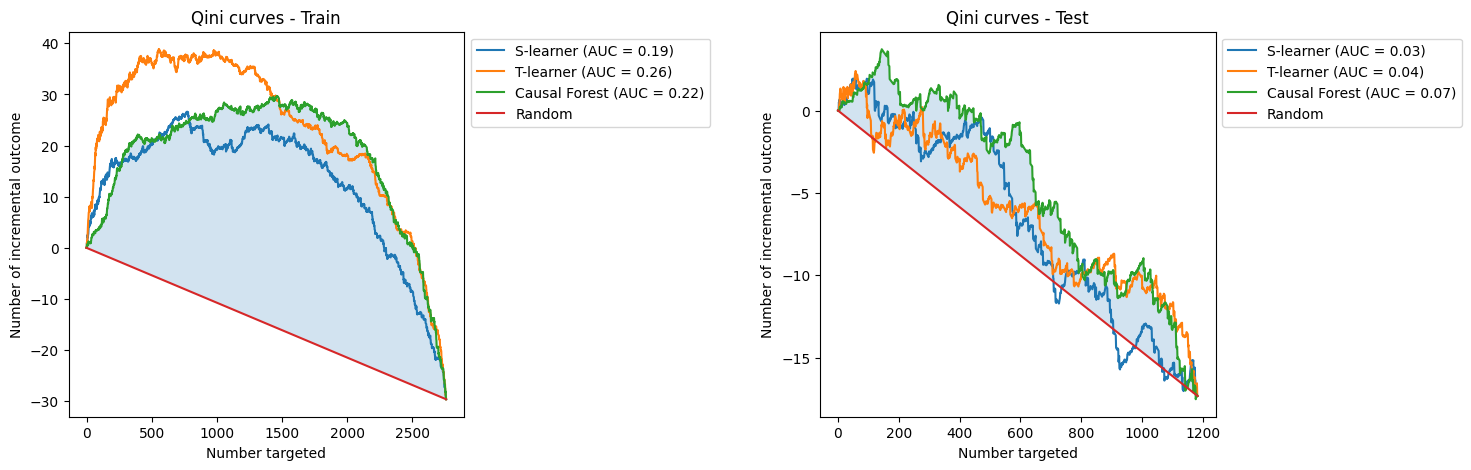

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14.8, 5))
plt.subplots_adjust(wspace=0.9)
ax1.set_title('Qini curves - Train')

plot_qini_curve(y_true=train["Y"].to_list(), uplift=regr_s.predict(train_x.assign(**{"W": 1})) - regr_s.predict(train_x.assign(**{"W": 0})), treatment=train["W"].to_list(), perfect=False, random=False, name="S-learner", ax=ax1)

plot_qini_curve(y_true=train["Y"].to_list(), uplift=(regr1_t.predict(train_x) - regr0_t.predict(train_x)).tolist(), treatment=train["W"].to_list(), perfect=False, random=False, name="T-learner", ax=ax1)

plot_qini_curve(y_true=train["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=train_x)).tolist(), treatment=train["W"].to_list(), perfect=False, name="Causal Forest", ax=ax1)

ax2.set_title('Qini curves - Test')

plot_qini_curve(y_true=test["Y"].to_list(), uplift=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})), treatment=test["W"].to_list(), perfect=False, random=False, name="S-learner", ax=ax2)

plot_qini_curve(y_true=test["Y"].to_list(), uplift=(regr1_t.predict(test_x) - regr0_t.predict(test_x)).tolist(), treatment=test["W"].to_list(), perfect=False, random=False, name="T-learner", ax=ax2)

plot_qini_curve(y_true=test["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=test_x)).tolist(), treatment=test["W"].to_list(), perfect=False, name="Causal Forest", ax=ax2)

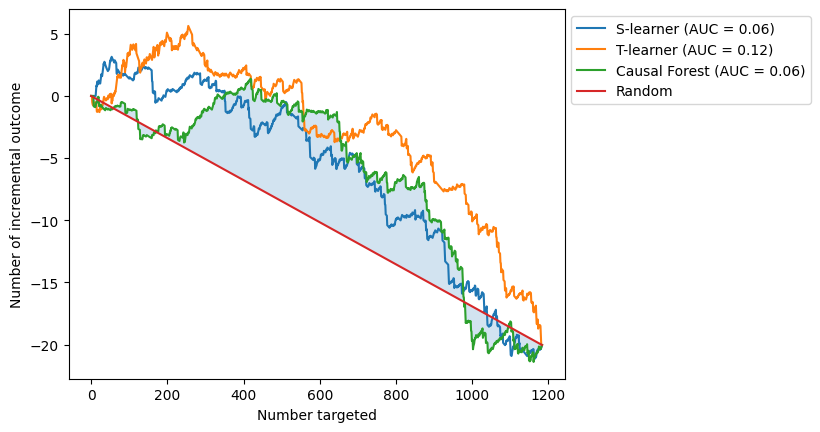

In [110]:
fig, ax = plt.subplots(1, 1)
plot_qini_curve(y_true=test["Y"].to_list(), uplift=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})), treatment=test["W"].to_list(), perfect=False, random=False, name="S-learner", ax=ax)

plot_qini_curve(y_true=test["Y"].to_list(), uplift=(regr1_t.predict(test_x) - regr0_t.predict(test_x)).tolist(), treatment=test["W"].to_list(), perfect=False, random=False, name="T-learner", ax=ax)

plot_qini_curve(y_true=test["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=test_x)).tolist(), treatment=test["W"].to_list(), perfect=False, name="Causal Forest", ax=ax)